# Naive Bayes on Amazon Fine Food Reviews

# Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

 1. Id
 2. ProductId - unique identifier for the product
 3. UserId - unqiue identifier for the user
 4. ProfileName
 5. HelpfulnessNumerator - number of users who found the review helpful
 6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
 7. Score - rating between 1 and 5
 8. Time - timestamp for the review
 9. Summary - brief summary of the review
 10.Text - text of the review

Objective:

* Given a review determine whether a review is positive or negative, by appling Naive Bayes algorithm and deciding the best Feature generation technique for given problem. Also to report the metrics for each iteration. Time based splitting to be followed.


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# 1. Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

# 2. Importing Required Packages

In [30]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import warnings
warnings.filterwarnings('ignore')

In [5]:
# creating sql connection string

con = sqlite3.connect('database.sqlite')

In [6]:
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [7]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 3. Time Based Splitting

In [8]:
import datetime

filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))

sortedData = filtered_data.sort_values('ProductId',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

#sording data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

print(final.shape)
final.head()

(364173, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08 05:30:00,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25 05:30:00,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02 05:30:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06 05:30:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03 05:30:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


# Exploratory Data Analysis

4. Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

# Observation:- 

It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# 5. Data Sampling

In [14]:
# Data Sampling
final = final.iloc[:100000,:]
print(final.shape)
print(final['Score'].value_counts())

(100000, 10)
positive    87730
negative    12270
Name: Score, dtype: int64


# 6. Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
8. After which we collect the words used to describe positive and negative reviews

In [15]:
# find sentences containing HTML tags

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1; 

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [19]:
import nltk
nltk.download('stopwords')

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Intel\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [20]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [21]:
# Finding most frequently occuring Positive and Negative words 

freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(10))
print("Most Common Negative Words : ",freq_dist_negative.most_common(10))

Most Common Positive Words :  [(b'like', 36906), (b'tast', 35305), (b'good', 30952), (b'flavor', 29987), (b'tea', 29849), (b'great', 29549), (b'love', 28268), (b'use', 27551), (b'one', 26049), (b'product', 24778)]
Most Common Negative Words :  [(b'tast', 7222), (b'like', 6589), (b'product', 5935), (b'one', 4429), (b'flavor', 4081), (b'tri', 3696), (b'would', 3646), (b'good', 3265), (b'use', 3054), (b'tea', 2861)]


In [22]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08 05:30:00,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25 05:30:00,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02 05:30:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
3,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06 05:30:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
4,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03 05:30:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


# Observations:-
    
    * I've performed the following Data preprocessing.

        > Removed Stop-words
        
        > Removed any punctuations or limited set of special characters like , or . or # etc.
        
        > Snowball Stemming the word (The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form)
        
        > Converted the word to lowercase
        
    * I've added a column called 'CleanedText' which displays the data after pre-processing of the review. So,Now we have 1000 reviews with 11 columns
    
    * Out of 364k reviews, I 've sampled the data to 50k and applied naive bayes.
    
    * I've calculated the feature importance of both positive and negative classes and printed the top ten most common words

# 7. Building Function to find Optimal Alpha value for Naive Bayes

**7.1 Bernoulli Naive Bayes**

In [23]:
# Container to store the results
final_results = {}

mu_final_results = {}

In [42]:
# Function for Bernoulli Naive Bayes

def runNB(X_tr_input,x_cv_input,y_tr_input,y_cv_input,VectorizationType):

        cv_scores = []
        Alpha_value = []
            
        j=0
        for i in range(1,30,2):
                nb = BernoulliNB(alpha=i)
                scores = cross_val_score(nb, X_tr_input, y_tr_input, cv=10, scoring='accuracy')
                cv_scores.append(scores.mean())
                Alpha_value.append(i)
                print('For Alpha = ', i,'Accuracy Score = ', cv_scores[j])
                j+=1
        print('BERNOULLI NAIVE BAYES')
        plt.plot(Alpha_value,cv_scores,'.-')
        plt.title('Alpha Value vs CV Scores')
        plt.ylabel('CV Scores')
        plt.xlabel('Alpha Value')
        plt.show()
        
        # changing to misclassification error
        MSE = [1 - x for x in cv_scores]
                
        # determining best alpha
        alpha_optimum = Alpha_value[MSE.index(min(MSE))]
        nb = BernoulliNB(alpha=alpha_optimum)
        
        # fitting the model on crossvalidation train
        nb.fit(X_tr_input, y_tr_input)
        
        
        # predict the response on the crossvalidation train
        pred = nb.predict(x_cv_input)
        print('The Accuracy of Bernoulli Naive Bayes with Alpha Value = ',alpha_optimum,'and ',VectorizationType,
        ' vectorization is: ',np.round((accuracy_score(y_cv_input, pred)*100),decimals = 2))
        final_results[VectorizationType] =accuracy_score(y_cv_input,pred)*100
        
        print("The Misclassification error for each Alpha value is : ", np.round(MSE,3))
        print('\nDetails for ',VectorizationType,'Vectorization:')
        print('*'*50)
        print('Accuracy for Bernoulli Naive Bayes algorithm with alpha =',alpha_optimum,' is ' ,np.round((accuracy_score(y_cv_input, pred)*100),decimals = 2))
        print('F1 score for Bernoulli Naive Bayes algorithm with alpha =',alpha_optimum,' is ' , np.round((f1_score(y_cv_input, pred,average= 'macro')*100),decimals = 2))
        print('Recall for Bernoulli Naive Bayes agorithm with alpha =',alpha_optimum,' is ' , np.round((recall_score(y_cv_input, pred,average= 'macro')*100),decimals = 2))
        print('Precision for Bernoulli Naive Bayes algorithm with aplha =',alpha_optimum,' is ' , np.round((precision_score(y_cv_input, pred,average= 'macro')*100),decimals = 2))
        print ('\n Classification report for Bernoulli Naive Bayes algorithm with alpha =',alpha_optimum,' is \n ' , classification_report(y_cv_input,pred))
        
        # Plot Confusion Matrix, F1 Score, Recall, Precision and Classification Report
        from sklearn.metrics import confusion_matrix
        import scikitplot.metrics as skplt
        skplt.plot_confusion_matrix(y_cv_input,pred)
        plt.title('Confusion matrix of Bernoulli Naive Bayes')
        plt.show()
        print('*'*200)

**7.2 Multinomial Naive Bayes**

In [43]:
# Function for Multinomial Naive Bayes

def runNB_Multi(X_tr_input,x_cv_input,y_tr_input,y_cv_input,VectorizationType):

        cv_scores = []
        Alpha_value = []
            
        j=0
        for i in range(1,30,2):
                nb = MultinomialNB(alpha=i)
                scores = cross_val_score(nb, X_tr_input, y_tr_input, cv=10, scoring='accuracy')
                cv_scores.append(scores.mean())
                Alpha_value.append(i)                
                print('For Alpha = ', i,'Accuracy Score = ', cv_scores[j])
                j+=1
        print("MULTINOMIAL NAIVE BAYES")
        plt.plot(Alpha_value,cv_scores,'.-')
        plt.title('Alpha Value vs CV Scores')
        plt.ylabel('CV Scores')
        plt.xlabel('Alpha Value')
        plt.show()
        
        # changing to misclassification error
        MSE = [1 - x for x in cv_scores]
                
        # determining best alpha
        alpha_optimum = Alpha_value[MSE.index(min(MSE))]
        nb = MultinomialNB(alpha=alpha_optimum)
        
        # fitting the model on crossvalidation train
        nb.fit(X_tr_input, y_tr_input)
        
        # predict the response on the crossvalidation train
        mu_pred = nb.predict(x_cv_input)
        print('The Accuracy of Multinomial Naive Bayes with Alpha Value = ',alpha_optimum,'and ',VectorizationType,
        ' vectorization is: ',np.round((accuracy_score(y_cv_input, mu_pred)*100),decimals = 2))
        mu_final_results[VectorizationType] =accuracy_score(y_cv_input,mu_pred)*100
        
        print("The Misclassification error for each Alpha value is : ", np.round(MSE,3))
        print('\nDetails for ',VectorizationType,'Vectorization:')
        print('*'*50)
        print('F1 score for Multinomial Naive Bayes algorithm with alpha =',alpha_optimum,' is ' , np.round((f1_score(y_cv_input, mu_pred,average= 'macro')*100),decimals = 2))
        print('Recall for Multinomial Naive Bayes agorithm with alpha =',alpha_optimum,' is ' , np.round((recall_score(y_cv_input, mu_pred,average= 'macro')*100),decimals = 2))
        print('Precision for Multinomial Naive Bayes algorithm with aplha =',alpha_optimum,' is ' , np.round((precision_score(y_cv_input, mu_pred,average= 'macro')*100),decimals = 2))
        print ('\n Classification report for Multinomial Naive Bayes algorithm with alpha =',alpha_optimum,' is \n ' , classification_report(y_cv_input,mu_pred))
        
        # Plot Confusion Matrix, F1 Score, Recall, Precision and Classification Report
        from sklearn.metrics import confusion_matrix
        import scikitplot.metrics as skplt
        skplt.plot_confusion_matrix(y_cv_input,mu_pred)
        plt.title('Confusion matrix of Multinomial Naive Bayes')
        plt.show()

# Observations:-

    * I 've splitted the data into train, test and cross validation data set.
    
    * I've build a function to find optimal Alpha value for Naive Bayes.
    
    * I've created a odd list (Alpha_Value) of Alpha for Naive Bayes and an empty list to hold cross validation scores (cv_scores)
    
    * I've performed Bernoulli Naive Bayes & Multinomial Naive Bayes
    
    * I've printed the values of Accuracy, F1 Score, Recall, Precision, confusion matrix for Naive Bayes.

# 8. Feature Generation Techniques

# 8.1 Using Bag of Words

For Alpha =  1 Accuracy Score =  0.8820000573417562
For Alpha =  3 Accuracy Score =  0.8714693242347975
For Alpha =  5 Accuracy Score =  0.8703264045916189
For Alpha =  7 Accuracy Score =  0.8708162588190266
For Alpha =  9 Accuracy Score =  0.8724489243792954
For Alpha =  11 Accuracy Score =  0.8733061005711896
For Alpha =  13 Accuracy Score =  0.8740612525911834
For Alpha =  15 Accuracy Score =  0.8746326770019305
For Alpha =  17 Accuracy Score =  0.8750000114501615
For Alpha =  19 Accuracy Score =  0.8754489827172354
For Alpha =  21 Accuracy Score =  0.8756122563549205
For Alpha =  23 Accuracy Score =  0.8759591826364865
For Alpha =  25 Accuracy Score =  0.8762653009230845
For Alpha =  27 Accuracy Score =  0.8764285745624697
For Alpha =  29 Accuracy Score =  0.8764693950547819
BERNOULLI NAIVE BAYES


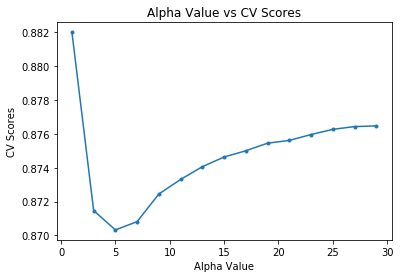

The Accuracy of Bernoulli Naive Bayes with Alpha Value =  1 and  Bag of Words  vectorization is:  88.64
The Misclassification error for each Alpha value is :  [0.118 0.129 0.13  0.129 0.128 0.127 0.126 0.125 0.125 0.125 0.124 0.124
 0.124 0.124 0.124]

Details for  Bag of Words Vectorization:
**************************************************
Accuracy for Bernoulli Naive Bayes algorithm with alpha = 1  is  88.64
F1 score for Bernoulli Naive Bayes algorithm with alpha = 1  is  70.73
Recall for Bernoulli Naive Bayes agorithm with alpha = 1  is  68.39
Precision for Bernoulli Naive Bayes algorithm with aplha = 1  is  74.32

 Classification report for Bernoulli Naive Bayes algorithm with alpha = 1  is 
               precision    recall  f1-score   support

   negative       0.57      0.41      0.48      2646
   positive       0.92      0.95      0.94     18354

avg / total       0.87      0.89      0.88     21000



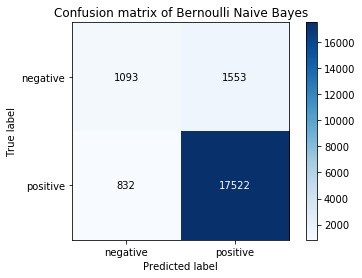

********************************************************************************************************************************************************************************************************
For Alpha =  1 Accuracy Score =  0.9062041600090132
For Alpha =  3 Accuracy Score =  0.9015305698033964
For Alpha =  5 Accuracy Score =  0.8904081998597538
For Alpha =  7 Accuracy Score =  0.8841020107004722
For Alpha =  9 Accuracy Score =  0.8807754967139536
For Alpha =  11 Accuracy Score =  0.8790407986553216
For Alpha =  13 Accuracy Score =  0.8780816191425336
For Alpha =  15 Accuracy Score =  0.8777755091857984
For Alpha =  17 Accuracy Score =  0.8773877582444392
For Alpha =  19 Accuracy Score =  0.8773673500811737
For Alpha =  21 Accuracy Score =  0.8773673500811737
For Alpha =  23 Accuracy Score =  0.8772449052656635
For Alpha =  25 Accuracy Score =  0.8771836807758675
For Alpha =  27 Accuracy Score =  0.8771836807758675
For Alpha =  29 Accuracy Score =  0.8771632726126022
MULTINOMI

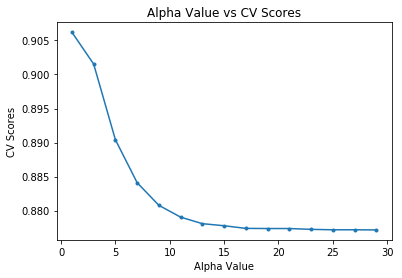

The Accuracy of Multinomial Naive Bayes with Alpha Value =  1 and  Bag of Words  vectorization is:  91.21
The Misclassification error for each Alpha value is :  [0.094 0.098 0.11  0.116 0.119 0.121 0.122 0.122 0.123 0.123 0.123 0.123
 0.123 0.123 0.123]

Details for  Bag of Words Vectorization:
**************************************************
F1 score for Multinomial Naive Bayes algorithm with alpha = 1  is  77.85
Recall for Multinomial Naive Bayes agorithm with alpha = 1  is  75.16
Precision for Multinomial Naive Bayes algorithm with aplha = 1  is  81.58

 Classification report for Multinomial Naive Bayes algorithm with alpha = 1  is 
               precision    recall  f1-score   support

   negative       0.70      0.54      0.61      2646
   positive       0.94      0.97      0.95     18354

avg / total       0.91      0.91      0.91     21000



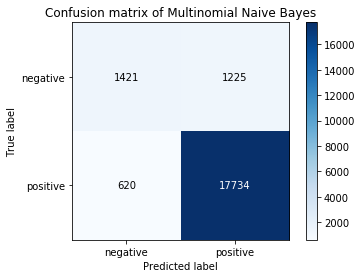

In [44]:
#Bag of Words
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final['CleanedText'], final['Score'], random_state = 0,test_size = 0.3)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

vect = CountVectorizer().fit(X_tr)
X_tr_vectorized = vect.transform(X_tr)
x_cv_vectorized = vect.transform(X_cv)
runNB(X_tr_vectorized, x_cv_vectorized, y_tr, y_cv,'Bag of Words')
runNB_Multi(X_tr_vectorized, x_cv_vectorized, y_tr, y_cv,'Bag of Words')

# 8.2 Using TF-IDF

For Alpha =  1 Accuracy Score =  0.8881429603524085
For Alpha =  3 Accuracy Score =  0.8732245845379092
For Alpha =  5 Accuracy Score =  0.8660204611964424
For Alpha =  7 Accuracy Score =  0.8623673374835311
For Alpha =  9 Accuracy Score =  0.8606938097765358
For Alpha =  11 Accuracy Score =  0.8593468626660629
For Alpha =  13 Accuracy Score =  0.8594080746534145
For Alpha =  15 Accuracy Score =  0.8605712983170223
For Alpha =  17 Accuracy Score =  0.8607753507943053
For Alpha =  19 Accuracy Score =  0.8609590159270303
For Alpha =  21 Accuracy Score =  0.8615508651556685
For Alpha =  23 Accuracy Score =  0.8620202570782519
For Alpha =  25 Accuracy Score =  0.8627753799496753
For Alpha =  27 Accuracy Score =  0.8637141346411721
For Alpha =  29 Accuracy Score =  0.8646120979974269
BERNOULLI NAIVE BAYES


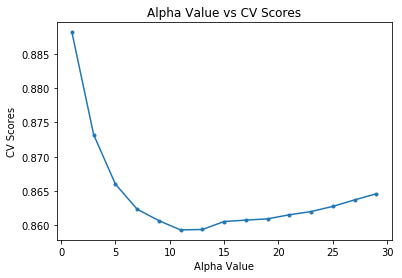

The Accuracy of Bernoulli Naive Bayes with Alpha Value =  1 and  TF-IDF  vectorization is:  88.78
The Misclassification error for each Alpha value is :  [0.112 0.127 0.134 0.138 0.139 0.141 0.141 0.139 0.139 0.139 0.138 0.138
 0.137 0.136 0.135]

Details for  TF-IDF Vectorization:
**************************************************
Accuracy for Bernoulli Naive Bayes algorithm with alpha = 1  is  88.78
F1 score for Bernoulli Naive Bayes algorithm with alpha = 1  is  74.63
Recall for Bernoulli Naive Bayes agorithm with alpha = 1  is  74.74
Precision for Bernoulli Naive Bayes algorithm with aplha = 1  is  74.52

 Classification report for Bernoulli Naive Bayes algorithm with alpha = 1  is 
               precision    recall  f1-score   support

   negative       0.55      0.56      0.56      2646
   positive       0.94      0.94      0.94     18354

avg / total       0.89      0.89      0.89     21000



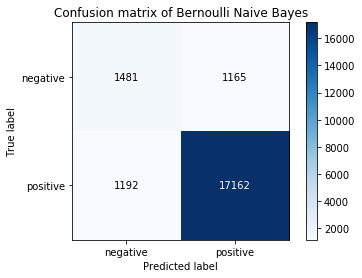

********************************************************************************************************************************************************************************************************
For Alpha =  1 Accuracy Score =  0.8861632851932452
For Alpha =  3 Accuracy Score =  0.8784285995656583
For Alpha =  5 Accuracy Score =  0.8774081622419228
For Alpha =  7 Accuracy Score =  0.8773061297554593
For Alpha =  9 Accuracy Score =  0.8773265337546432
For Alpha =  11 Accuracy Score =  0.8773265337546432
For Alpha =  13 Accuracy Score =  0.8773265337546432
For Alpha =  15 Accuracy Score =  0.8773265337546432
For Alpha =  17 Accuracy Score =  0.8773265337546432
For Alpha =  19 Accuracy Score =  0.8773265337546432
For Alpha =  21 Accuracy Score =  0.8773265337546432
For Alpha =  23 Accuracy Score =  0.8773265337546432
For Alpha =  25 Accuracy Score =  0.8773265337546432
For Alpha =  27 Accuracy Score =  0.8773265337546432
For Alpha =  29 Accuracy Score =  0.8773265337546432
MULTINOMI

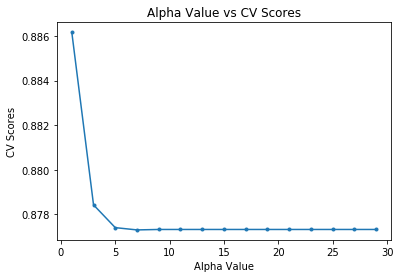

The Accuracy of Multinomial Naive Bayes with Alpha Value =  1 and  TF-IDF  vectorization is:  88.4
The Misclassification error for each Alpha value is :  [0.114 0.122 0.123 0.123 0.123 0.123 0.123 0.123 0.123 0.123 0.123 0.123
 0.123 0.123 0.123]

Details for  TF-IDF Vectorization:
**************************************************
F1 score for Multinomial Naive Bayes algorithm with alpha = 1  is  55.36
Recall for Multinomial Naive Bayes agorithm with alpha = 1  is  54.6
Precision for Multinomial Naive Bayes algorithm with aplha = 1  is  87.29

 Classification report for Multinomial Naive Bayes algorithm with alpha = 1  is 
               precision    recall  f1-score   support

   negative       0.86      0.09      0.17      2646
   positive       0.88      1.00      0.94     18354

avg / total       0.88      0.88      0.84     21000



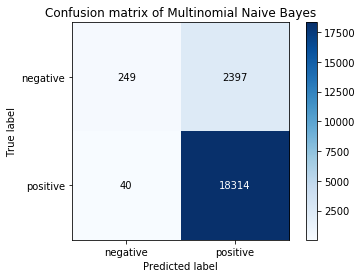

In [45]:
# Applying TFIDF

vect_tfidf = TfidfVectorizer(min_df = 5).fit(X_tr)

# Vectorizing the datsets
X_tr_vectorized = vect_tfidf.transform(X_tr)
x_cv_vectorized = vect_tfidf.transform(X_cv)

runNB(X_tr_vectorized,x_cv_vectorized,y_tr,y_cv,'TF-IDF')
runNB_Multi(X_tr_vectorized, x_cv_vectorized, y_tr, y_cv,'TF-IDF')

# 8. Naive Bayes on Amazon Fine Food Reviews Data set - Tabular Result

**8.1 Bernoulli Naive Bayes**

In [46]:
print("BERNOULLI NAIVE BAYES")
dataframe = pd.DataFrame(
{
    
    "Model": ['BOW','TF-IDF'],
    "Hyper Parameter (Alpha=)": [1,1],
    "Accuracy (%)": [88.64,88.78],
    "Test Error": [11.8,11.2],
    "F1 Score (%)": [70.73,74.63],
    "Recall (%)": [68.39,74.74],
    "Precision (%)": [74.32,74.52]
}

)
dataframe

BERNOULLI NAIVE BAYES


,Model,Hyper Parameter (Alpha=),Accuracy (%),Test Error,F1 Score (%),Recall (%),Precision (%)
0,BOW,1,88.64,11.8,70.73,68.39,74.32
1,TF-IDF,1,88.78,11.2,74.63,74.74,74.52


**8.2 Multinomial Naive Bayes**

In [47]:
print("Multinomial NAIVE BAYES")
dataframe = pd.DataFrame(
{
    
    "Model": ['BOW','TF-IDF'],
    "Hyper Parameter (Alpha=)": [1,1],
    "Accuracy (%)": [91.21,88.4],
    "Test Error": [9.4,11.4],
    "F1 Score (%)": [77.85,55.36],
    "Recall (%)": [75.16,54.6],
    "Precision (%)": [81.58,87.29]
}

)
dataframe

Multinomial NAIVE BAYES


,Model,Hyper Parameter (Alpha=),Accuracy (%),Test Error,F1 Score (%),Recall (%),Precision (%)
0,BOW,1,91.21,9.4,77.85,75.16,81.58
1,TF-IDF,1,88.40,11.4,55.36,54.60,87.29


# 9. Conclusion: 
    
* The result of feature generation techniques and machine learning algorithms vary by application. But by comparing the accuracy of 2 developed models, Multinomial Naive Bayes with TF-IDF feature generation technique gives accuracy more than 91% which is the best to predict the polarity of reviews among all models. The best optimal Alpha value is 1.